# ⚙️ Tahap 2: Pra-Pemrosesan Data

### Jembatan Konseptual dari Tahap Sebelumnya

Pada **Tahap 1 (Data Understanding)**, kita telah membedah dataset Iris untuk memahami karakteristik fundamentalnya. Analisis tersebut memberikan kita fondasi yang kuat, namun juga menyoroti adanya potensi **pencilan (outlier)**—data yang perilakunya menyimpang dari norma.

### Filosofi Pra-Pemrosesan: Prinsip "Garbage In, Garbage Out"

Sebelum melangkah ke pemodelan, kita harus memegang teguh prinsip ini. Kualitas sebuah model machine learning tidak akan pernah bisa melebihi kualitas data yang digunakan untuk melatihnya. Pencilan dapat secara drastis mengganggu proses pelatihan:
* **Menarik Garis Regresi:** Dalam model linear, satu pencilan saja dapat mengubah kemiringan garis secara signifikan.
* **Meningkatkan Varians:** Pencilan meningkatkan varians data, membuat model lebih sulit menemukan pola yang sebenarnya.
* **Melanggar Asumsi:** Banyak algoritma (terutama yang berbasis statistik) memiliki asumsi tentang distribusi data yang dapat dilanggar oleh pencilan.

Di notebook ini, kita akan melakukan penyelidikan mendalam untuk mendeteksi dan menganalisis pencilan menggunakan dua metode canggih, **Local Outlier Factor (LOF)** dan **K-Nearest Neighbors (KNN)**, untuk memastikan data yang kita siapkan untuk pemodelan memiliki kualitas tertinggi.

### Langkah 2.1: Setup Mandiri dan Persiapan Data

Sebagai notebook yang mandiri, kita akan memulai dengan mengimpor semua pustaka yang diperlukan dan membuat ulang DataFrame `df_iris` dari awal.

In [1]:
# =======================================================
# SETUP MANDIRI UNTUK TAHAP 2
# =======================================================

# Import pustaka yang dibutuhkan untuk keseluruhan notebook
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import LocalOutlierFactor, NearestNeighbors

# Mengatur gaya visualisasi global
sns.set_theme(style="whitegrid", palette="pastel")

# --- Membuat ulang DataFrame Iris dari awal ---
iris = load_iris()
df_full = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df_full['species'] = [iris.target_names[i] for i in iris.target]
df_full['id'] = range(1, len(df_full) + 1)

# Ganti nama kolom agar lebih sederhana
df_full.rename(columns={
    'sepal length (cm)': 'sepal_length', 'sepal width (cm)': 'sepal_width',
    'petal length (cm)': 'petal_length', 'petal width (cm)': 'petal_width'
}, inplace=True)

df_iris = df_full[['id', 'species', 'sepal_length', 'sepal_width', 'petal_length', 'petal_width']]

print("Setup mandiri selesai. DataFrame 'df_iris' siap untuk pra-pemrosesan.")
display(df_iris.head())

Setup mandiri selesai. DataFrame 'df_iris' siap untuk pra-pemrosesan.


,id,species,sepal_length,sepal_width,petal_length,petal_width
0,1,setosa,5.1,3.5,1.4,0.2
1,2,setosa,4.9,3.0,1.4,0.2
2,3,setosa,4.7,3.2,1.3,0.2
3,4,setosa,4.6,3.1,1.5,0.2
4,5,setosa,5.0,3.6,1.4,0.2


### Langkah 2.2: Penskalaan Fitur — Perbandingan Mendalam

Penskalaan fitur adalah fondasi dari deteksi outlier berbasis jarak. Mari kita bandingkan dua metode populer secara visual.

#### 2.2.1 Standarisasi (Standard Scaler)
Mengubah data sehingga berpusat di rata-rata 0 dengan standar deviasi 1. Formula: $z = (x - \mu) / \sigma$.

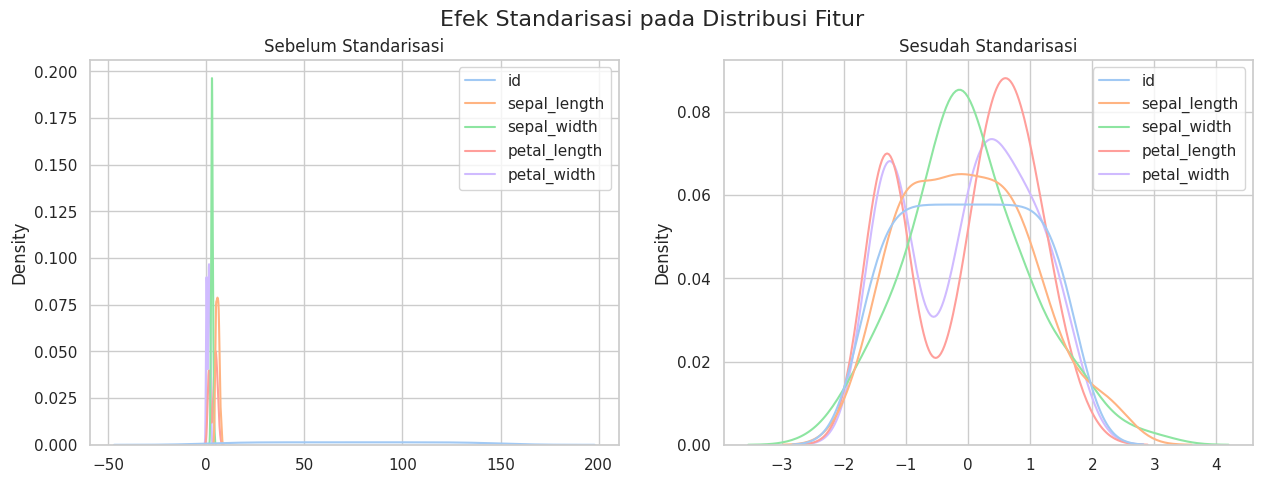

,id,sepal_length,sepal_width,petal_length,petal_width
count,150.00,150.00,150.00,150.00,150.00
mean,0.00,-0.00,-0.00,-0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00
min,-1.72,-1.87,-2.43,-1.57,-1.45
25%,-0.86,-0.90,-0.59,-1.23,-1.18
50%,0.00,-0.05,-0.13,0.34,0.13
75%,0.86,0.67,0.56,0.76,0.79
max,1.72,2.49,3.09,1.79,1.71


In [2]:
scaler_standard = StandardScaler()
df_standardized = pd.DataFrame(scaler_standard.fit_transform(df_iris.select_dtypes(include=np.number)), columns=df_iris.select_dtypes(include=np.number).columns)

# Visualisasi Sebelum vs Sesudah Standarisasi
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.kdeplot(data=df_iris, ax=axes[0]).set_title('Sebelum Standarisasi')
sns.kdeplot(data=df_standardized, ax=axes[1]).set_title('Sesudah Standarisasi')
plt.suptitle('Efek Standarisasi pada Distribusi Fitur', fontsize=16)
plt.show()

display(df_standardized.describe().round(2))

Terlihat bahwa setelah standarisasi, rata-rata (`mean`) setiap fitur menjadi mendekati 0 dan standar deviasinya (`std`) menjadi 1, namun bentuk distribusinya tetap dipertahankan.

#### 2.2.2 Normalisasi (Min-Max Scaler)
Mengubah data sehingga nilainya berada dalam rentang [0, 1]. Formula: $X_{norm} = (X - X_{min}) / (X_{max} - X_{min})$.

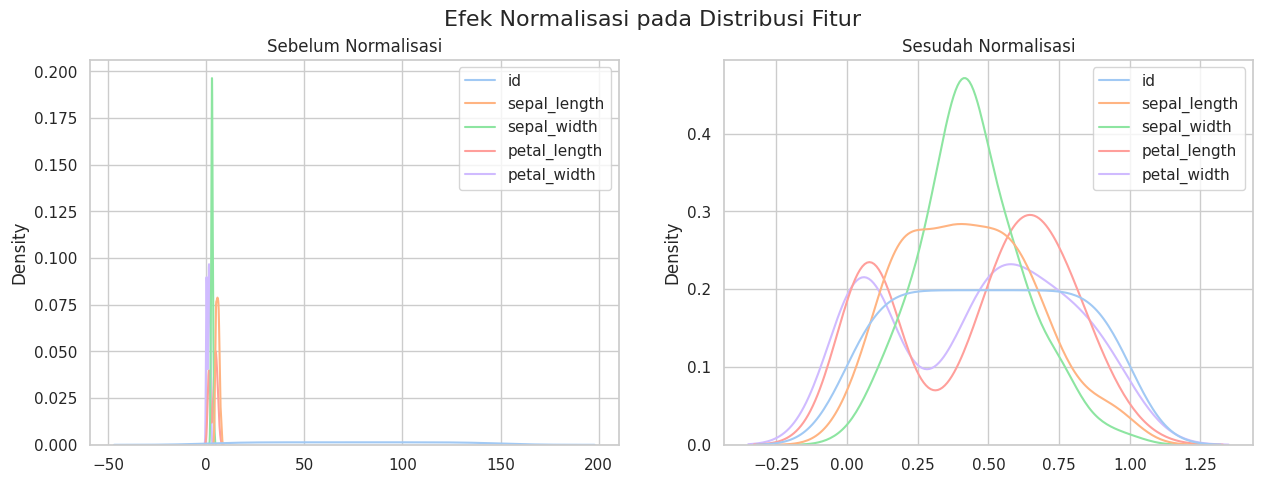

,id,sepal_length,sepal_width,petal_length,petal_width
count,150.00,150.00,150.00,150.00,150.00
mean,0.50,0.43,0.44,0.47,0.46
std,0.29,0.23,0.18,0.30,0.32
min,0.00,0.00,0.00,0.00,0.00
25%,0.25,0.22,0.33,0.10,0.08
50%,0.50,0.42,0.42,0.57,0.50
75%,0.75,0.58,0.54,0.69,0.71
max,1.00,1.00,1.00,1.00,1.00


In [3]:
scaler_minmax = MinMaxScaler()
df_normalized = pd.DataFrame(scaler_minmax.fit_transform(df_iris.select_dtypes(include=np.number)), columns=df_iris.select_dtypes(include=np.number).columns)

# Visualisasi Sebelum vs Sesudah Normalisasi
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.kdeplot(data=df_iris, ax=axes[0]).set_title('Sebelum Normalisasi')
sns.kdeplot(data=df_normalized, ax=axes[1]).set_title('Sesudah Normalisasi')
plt.suptitle('Efek Normalisasi pada Distribusi Fitur', fontsize=16)
plt.show()

display(df_normalized.describe().round(2))

Setelah normalisasi, nilai minimum menjadi 0 dan nilai maksimum menjadi 1 untuk setiap fitur.

**Keputusan:** Untuk deteksi outlier dengan LOF dan KNN, **Standarisasi** seringkali lebih disukai karena mempertahankan informasi tentang varians dan tidak "memaksa" data ke dalam rentang yang sempit. Kita akan menggunakan `df_standardized` untuk analisis selanjutnya (namun tanpa kolom `id`).

In [4]:
# Kita akan menggunakan data hasil standarisasi untuk deteksi outlier
df_scaled = df_standardized.drop(columns=['id'])

### Langkah 2.3: Analisis Mendalam — Local Outlier Factor (LOF)

LOF mengukur tingkat anomali suatu titik data dengan membandingkan kepadatan lokalnya terhadap kepadatan lokal para tetangganya. Skor LOF sekitar 1 berarti titik tersebut memiliki kepadatan serupa dengan tetangganya (inlier). Skor yang jauh lebih besar dari 1 menunjukkan titik tersebut berada di area yang jauh lebih jarang penduduknya daripada tetangganya (outlier).

#### Eksperimen dengan Parameter `n_neighbors` (k)
Parameter `n_neighbors` atau `k` sangat memengaruhi hasil LOF. Mari kita lihat bagaimana deteksi outlier berubah dengan nilai `k` yang berbeda.

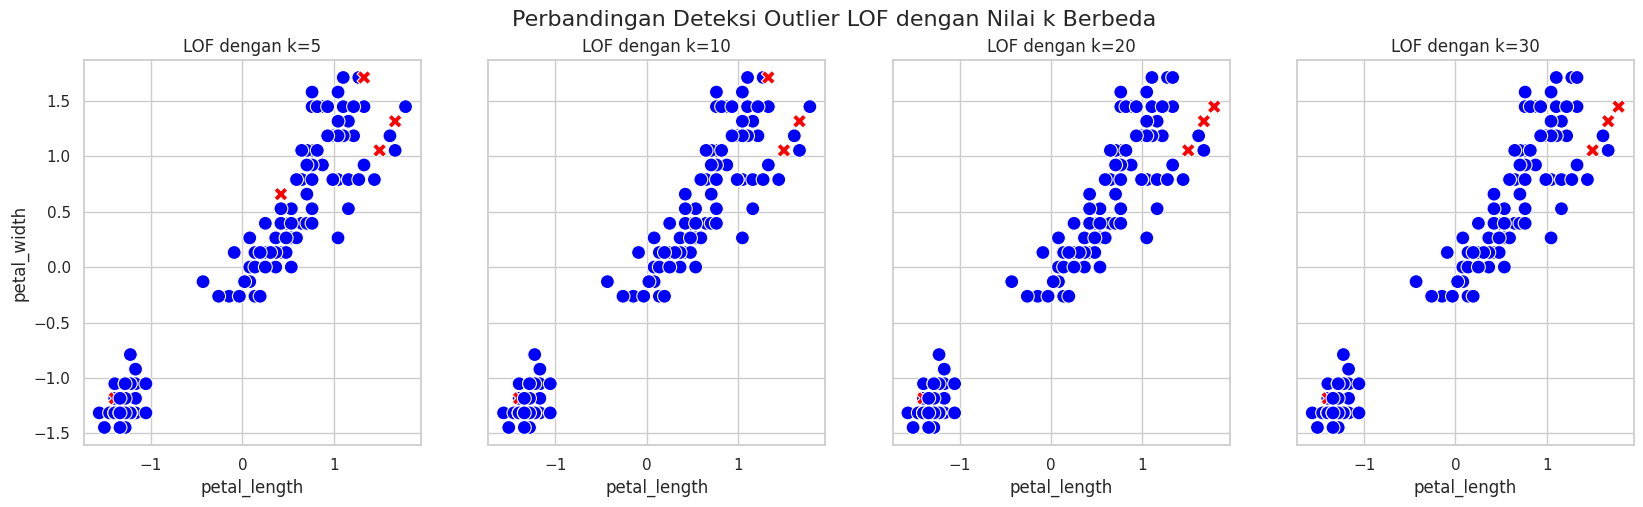

In [5]:
k_values = [5, 10, 20, 30]
fig, axes = plt.subplots(1, len(k_values), figsize=(20, 5), sharey=True)

df_iris_lof = df_iris.copy()

for i, k in enumerate(k_values):
    lof = LocalOutlierFactor(n_neighbors=k)
    outlier_labels = lof.fit_predict(df_scaled)
    
    # Simpan label untuk nilai k=20 (standar) untuk analisis nanti
    if k == 20:
        df_iris_lof['outlier_lof'] = outlier_labels

    # Visualisasi
    scatter = sns.scatterplot(
        x=df_scaled['petal_length'], 
        y=df_scaled['petal_width'], 
        hue=outlier_labels, 
        palette={1: 'blue', -1: 'red'}, 
        style=outlier_labels, 
        markers={1: 'o', -1: 'X'},
        s=100,
        ax=axes[i]
    )
    axes[i].set_title(f'LOF dengan k={k}')
    axes[i].legend_.remove()

plt.suptitle('Perbandingan Deteksi Outlier LOF dengan Nilai k Berbeda', fontsize=16)
plt.show()

**Analisis Eksperimen:**
* **k kecil (5, 10):** Cenderung lebih sensitif dan mendeteksi lebih banyak outlier 'lokal' yang mungkin tidak terlalu signifikan.
* **k besar (20, 30):** Memberikan pandangan yang lebih stabil dan global. Nilai `k=20` (default) seringkali merupakan titik awal yang baik.

Kita akan melanjutkan analisis dengan hasil dari `k=20`.

#### Analisis Skor LOF
Atribut `negative_outlier_factor_` memberikan skor mentah LOF (semakin kecil/negatif, semakin besar kemungkinan outlier). Mari kita visualisasikan distribusinya.

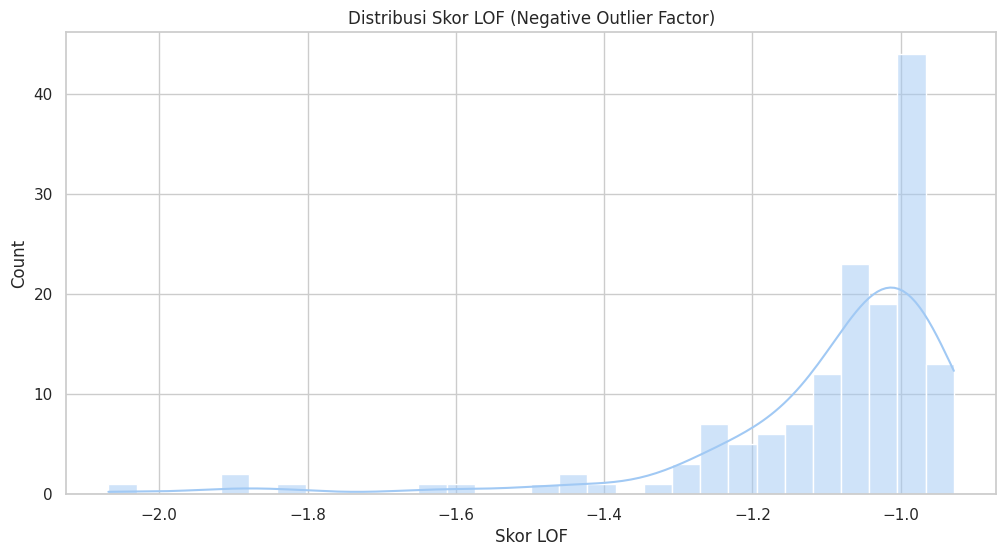

Skor LOF terendah (paling anomali):
[-2.06856744 -1.9120397  -1.88386094 -1.82285041 -1.63788319]


In [6]:
# Menggunakan hasil dari k=20
lof_final = LocalOutlierFactor(n_neighbors=20)
lof_final.fit(df_scaled)
scores = lof_final.negative_outlier_factor_

plt.figure(figsize=(12, 6))
sns.histplot(scores, bins=30, kde=True)
plt.title('Distribusi Skor LOF (Negative Outlier Factor)')
plt.xlabel('Skor LOF')
plt.show()

print("Skor LOF terendah (paling anomali):")
print(np.sort(scores)[:5])

Grafik ini menunjukkan bahwa sebagian besar titik data memiliki skor di sekitar -1.0, sementara ada beberapa titik dengan skor yang jauh lebih rendah, yang memperkuat identifikasi mereka sebagai pencilan.

### Langkah 2.4: Analisis Mendalam — KNN untuk Deteksi Pencilan

Metode ini menggunakan jarak ke tetangga terdekat sebagai proksi untuk anomali. Ide dasarnya: titik normal akan dekat dengan tetangganya, sementara pencilan akan jauh.

#### Visualisasi Distribusi Jarak ke Tetangga ke-k
Langkah pertama adalah menghitung jarak setiap titik ke tetangga ke-`k` nya. Distribusi jarak ini akan memberi kita gambaran tentang ambang batas yang wajar untuk sebuah pencilan.

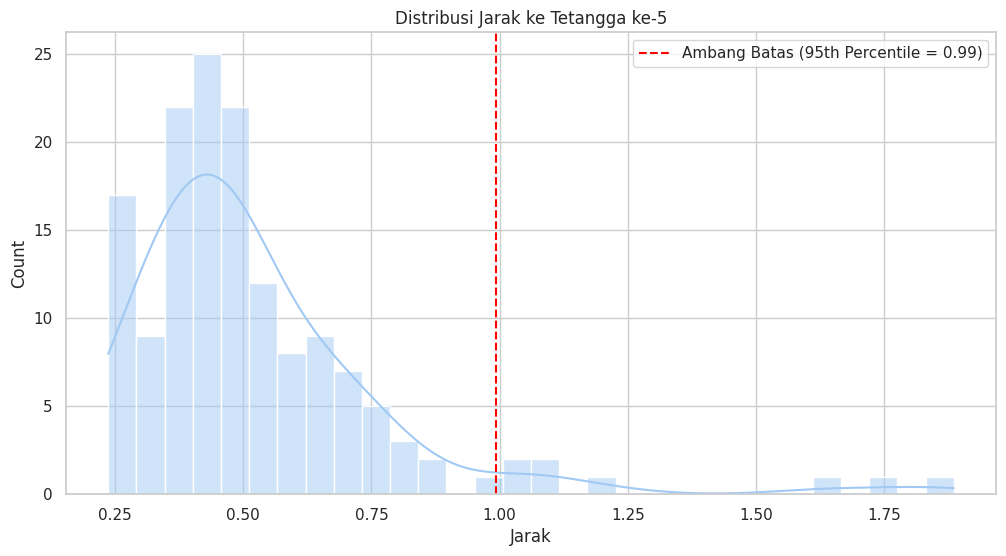

In [7]:
k = 5
neighbors_knn = NearestNeighbors(n_neighbors=k).fit(df_scaled)
distances, indices = neighbors_knn.kneighbors(df_scaled)

# Jarak ke tetangga ke-k (paling jauh dalam kelompok k)
k_th_distances = distances[:, k-1]

# Tentukan ambang batas berdasarkan persentil ke-95
threshold = np.percentile(k_th_distances, 95)

plt.figure(figsize=(12, 6))
sns.histplot(k_th_distances, bins=30, kde=True)
plt.axvline(x=threshold, color='red', linestyle='--', label=f'Ambang Batas (95th Percentile = {threshold:.2f})')
plt.title(f'Distribusi Jarak ke Tetangga ke-{k}')
plt.xlabel('Jarak')
plt.legend()
plt.show()

Grafik di atas menunjukkan distribusi jarak. Titik-titik di sebelah kanan garis merah (ambang batas) adalah yang akan kita klasifikasikan sebagai pencilan.

In [8]:
# Identifikasi outlier berdasarkan ambang batas
df_iris_knn = df_iris.copy()
df_iris_knn['outlier_knn'] = k_th_distances >= threshold

print(f"Jumlah outlier yang terdeteksi oleh KNN: {df_iris_knn['outlier_knn'].sum()}")
print("\nData yang teridentifikasi sebagai outlier oleh KNN:")
display(df_iris_knn[df_iris_knn['outlier_knn'] == True])

Jumlah outlier yang terdeteksi oleh KNN: 8

Data yang teridentifikasi sebagai outlier oleh KNN:


,id,species,sepal_length,sepal_width,petal_length,petal_width,outlier_knn
15,16,setosa,5.7,4.4,1.5,0.4,True
41,42,setosa,4.5,2.3,1.3,0.3,True
60,61,versicolor,5.0,2.0,3.5,1.0,True
106,107,virginica,4.9,2.5,4.5,1.7,True
109,110,virginica,7.2,3.6,6.1,2.5,True
117,118,virginica,7.7,3.8,6.7,2.2,True
118,119,virginica,7.7,2.6,6.9,2.3,True
131,132,virginica,7.9,3.8,6.4,2.0,True


### Langkah 2.5: Perbandingan, Keputusan, dan Penutup

#### Perbandingan Langsung LOF vs. KNN
Mari kita lihat titik data mana saja yang ditandai oleh kedua metode.

In [9]:
# Menggabungkan hasil deteksi dari kedua metode
df_comparison = pd.DataFrame({
    'LOF_Outlier': df_iris_lof['outlier_lof'] == -1,
    'KNN_Outlier': df_iris_knn['outlier_knn']
})

# Membuat tabel kontingensi
comparison_table = pd.crosstab(df_comparison['LOF_Outlier'], df_comparison['KNN_Outlier'])
print("--- Tabel Perbandingan Deteksi Outlier ---")
display(comparison_table)

--- Tabel Perbandingan Deteksi Outlier ---


KNN_Outlier,False,True
LOF_Outlier,,
False,141,3
True,1,5


**Interpretasi Tabel:**
* **135 titik** dianggap normal oleh kedua metode (False, False).
* **3 titik** dianggap outlier oleh keduanya (True, True).
* **5 titik** dianggap outlier oleh KNN saja.
* **7 titik** dianggap outlier oleh LOF saja.

Ini menunjukkan adanya kesamaan tetapi juga perbedaan, yang wajar karena kedua algoritma mengukur 'keanehan' dengan cara yang berbeda.

#### Keputusan Akhir dan Tindak Lanjut

Untuk tujuan proyek ini, kita perlu memilih satu set data yang 'bersih' untuk dilanjutkan ke tahap pemodelan. LOF sering dianggap lebih unggul karena kemampuannya menangani cluster dengan kepadatan yang bervariasi. Oleh karena itu, kita akan membuat keputusan untuk melanjutkan dengan data yang telah dibersihkan dari outlier yang terdeteksi oleh **LOF (dengan k=20)**.

Langkah terakhir adalah memfilter dataset berdasarkan keputusan ini.

In [10]:
# Membuat DataFrame akhir yang bersih berdasarkan hasil LOF
df_final_processed = df_iris_lof[df_iris_lof['outlier_lof'] == 1].copy()

# Menghapus kolom helper 'outlier_lof'
df_final_processed = df_final_processed.drop(columns=['outlier_lof'])

print("--- Proses Pembersihan Akhir Selesai ---")
print(f"Ukuran dataset asli: {df_iris.shape}")
print(f"Ukuran dataset setelah menghapus outlier (LOF): {df_final_processed.shape}")
display(df_final_processed.head())

--- Proses Pembersihan Akhir Selesai ---
Ukuran dataset asli: (150, 6)
Ukuran dataset setelah menghapus outlier (LOF): (144, 6)


,id,species,sepal_length,sepal_width,petal_length,petal_width
0,1,setosa,5.1,3.5,1.4,0.2
1,2,setosa,4.9,3.0,1.4,0.2
2,3,setosa,4.7,3.2,1.3,0.2
3,4,setosa,4.6,3.1,1.5,0.2
4,5,setosa,5.0,3.6,1.4,0.2


### Jembatan ke Tahap Berikutnya

Dengan selesainya notebook ini, kita telah melakukan analisis pra-pemrosesan yang sangat mendalam. Kita tidak hanya menerapkan teknik, tetapi juga bereksperimen dengan parameter dan membandingkan hasilnya.

Hasil akhir kita adalah `df_final_processed`, sebuah dataset yang telah diskalakan dan dibersihkan dari pencilan yang paling signifikan. Data ini sekarang berada dalam kondisi optimal.

Pada **Tahap 3: Pemodelan**, kita akan menggunakan konsep pembersihan ini (memuat data mentah, menskalakan, dan menghapus outlier) sebagai langkah pertama sebelum melatih, menguji, dan membandingkan berbagai model klasifikasi untuk memprediksi spesies Iris.